In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import os
os.environ['PATH_SOURCE_DATA'] = '/workspace/projects/boostdm/nature-release/source-data'

In [23]:
import os
import sys
sys.path.append('./scripts/')
import pickle
import gzip
import functools
import operator
import glob

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import numpy as np
import pandas as pd

from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc

import matplotlib.pyplot as plt

import conf
import oncotree

os.makedirs("raw_plots",exist_ok=True)
os.makedirs("source_data",exist_ok=True)

In [24]:
method_label = {'boostDM_score': 'boostDM',
                'chasm_score': 'CHASMplus',
                'cadd_score': 'CADD',
                'tp53_kato': 'TP53 (Kato et al.)',
                'tp53_giacomelli': 'TP53 (Giacomelli et al.)',
                'vest4': 'VEST4',
                'sift': 'SIFT',
                'sift4g': 'SIFT4G',
                'Polyphen2_HVAR': 'Polyphen2 (HVAR)',
                'Polyphen2_HDIV': 'Polyphen2 (HDIV)',
                'fathmm': 'FATHMM',
                'MutationAssessor': 'MutationAssessor',
                'ras_bandaru': 'RAS (Bandaru et al.)',
                'pten_mighell': 'PTEN (Mighell et al.)'
                }

palette_boostdm = {'boostDM_score': '#ac0f0f', 'boostDM_score_strict': '#ad6f0f'}
palette_bioinfo = dict(zip(['chasm_score', 'cadd_score', 'vest4', 'sift', 'sift4g', 'Polyphen2_HVAR', 'Polyphen2_HDIV', 
                            'fathmm', 'MutationAssessor'], 
                           ['pink', '#b491c8', '#1565c0', '#663a82', '#1e88e5', '#90caf9', 'black', '#3c1361', '#52307c', ]))
palette_experimental = dict(zip(['tp53_kato', 'tp53_giacomelli', 'pten_mighell', 'ras_bandaru'],
                                ['#607c3c', '#b5e550', '#ececa3', '#abc32f']))

palettes = {}
palettes.update(palette_boostdm)
palettes.update(palette_bioinfo)
palettes.update(palette_experimental)

cv_path = os.path.join(os.environ['PATH_SOURCE_DATA'], 'benchmark-cvdata')

In [25]:
# Precision-Recall Curve

def trycatch(f):
    
    def func(*args, **kwargs):
        x = None
        try:
            x = f(*args, **kwargs)
        except Exception as e:
            pass
        return x
    return func


def plot_pr_curve(testy, model_probs, ax, **kwargs):
    
    # plot model precision-recall curve
    precision, recall, _ = precision_recall_curve(testy, model_probs)
    ax.plot(recall, precision, **kwargs)
    
    # axis labels
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    
    # axis limits
    ax.set_ylim(0.5, 1.01)
    

@trycatch
def plot_prc(gene, ttype, score, ax=None, plot=True, **kwargs):
    
    if score in ['chasm_score']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_chasm/{gene}.{ttype}.cv_chasm.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[(df[score] != '.') & (~df[score].isnull())]
        X = df[score].values.reshape(-1, 1)
        y = df['driver'].values
    
    elif score in ['cadd_score']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_cadd/{gene}.{ttype}.cv_cadd.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[~df[score].isnull()]
        X = df[score].values.reshape(-1, 1)
        y = df['driver'].values
    
    elif score in ['boostDM_score']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_boostdm/{gene}.{ttype}.cv_boostdm.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[(~df[score].isnull())]
        X = df[score].values.reshape(-1, 1)
        y = df['driver'].values
    
    elif score in ['tp53_kato']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_tp53_kato/{gene}.{ttype}.cv_tp53.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[(~df['tp53_score'].isnull())]
        X = df['tp53_score'].values.reshape(-1, 1)
        y = df['driver'].values
    
    elif score in ['pten_mighell']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_pten_mighell/{gene}.{ttype}.cv_pten.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[(~df['pten_score'].isnull())]
        X = df['pten_score'].values.reshape(-1, 1)
        y = df['driver'].values
    
    elif score in ['ras_bandaru']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_ras_bandaru/{gene}.{ttype}.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[(~df['ras_score'].isnull())]
        X = df['ras_score'].values.reshape(-1, 1)
        y = df['driver'].values
        
    elif score in ['tp53_giacomelli']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_tp53_giacomelli/{gene}.{ttype}.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[(~df['tp53_natgen_score'].isnull())]
        X = df['tp53_natgen_score'].values.reshape(-1, 1)
        y = df['driver'].values
    
    elif score in ['sift']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_{score}/{gene}.{ttype}.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[(df['SIFT'] != '.') & (~df['SIFT'].isnull())]
        X = df['SIFT'].values.reshape(-1, 1)
        y = df['driver'].values
        
    elif score in ['sift4g']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_{score}/{gene}.{ttype}.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[(df['SIFT4G'] != '.') & (~df['SIFT4G'].isnull())]
        X = df['SIFT4G'].values.reshape(-1, 1)
        y = df['driver'].values
        
    elif score in ['Polyphen2_HDIV']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_{score}/{gene}.{ttype}.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[(df[score] != '.') & (~df[score].isnull())]
        X = df[score].values.reshape(-1, 1)
        y = df['driver'].values
    
    elif score in ['Polyphen2_HVAR']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_{score}/{gene}.{ttype}.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[(df[score] != '.') & (~df[score].isnull())]
        X = df[score].values.reshape(-1, 1)
        y = df['driver'].values
        
    elif score in ['fathmm']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_{score}/{gene}.{ttype}.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[(df['FATHMM'] != '.') & (~df['FATHMM'].isnull())]
        X = df['FATHMM'].values.reshape(-1, 1)
        y = df['driver'].values
        
    elif score in ['MutationAssessor']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_{score}/{gene}.{ttype}.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[(df[score] != '.') & (~df[score].isnull())]
        X = df[score].values.reshape(-1, 1)
        y = df['driver'].values

    elif score in ['vest4']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_{score}/{gene}.{ttype}.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[(df['VEST4'] != '.') & (~df['VEST4'].isnull())]
        X = df['VEST4'].values.reshape(-1, 1)
        y = df['driver'].values
        
    # fit simple logistic model
    model = LogisticRegression(solver='lbfgs')
    
    # number of mutations
    n = len(y)
    positive = sum(y)
    negative = n - positive
    
    model.fit(X, y)
    yhat = model.predict_proba(X)
    probs = yhat[:, 1]
    assert(X.shape[0] == len(y))

    # calculate the precision-recall auc
    precision, recall, _ = precision_recall_curve(y, probs)
    auc_score = auc(recall, precision)

    # plot precision-recall curves
    if plot:
        plot_pr_curve(y, probs, ax, label=f'{method_label[score]}: auPRC={auc_score:.2}', **kwargs)
    
    return auc_score, precision, recall, positive, negative

# Extended Figure 3a

In [26]:
def plot_tp53_boxplot():
    
    gene = 'TP53'
    fig, ax = plt.subplots(figsize=(10,3))
    tumor_types = {'PRAD', 'ESCA', 'LUSC', 'LUAD', 'UCEC', 'PAAD', 'OV', 'BLCA', 'GBM'}
    
    scores, scores_full = zip(*list(method_label.items()))
        
    box = [[] for _ in scores]
    for ttype in tumor_types:
        for i, score in enumerate(scores):
            auc, _, _, _, _ = plot_prc(gene, ttype, score, ax=ax, plot=False, lw=4, alpha=1)
            box[i].append(auc)
    
    sorted_index = np.argsort(list(map(np.nanmedian, box)))[::-1]
    box = [box[i] for i in sorted_index]
    scores_full = [scores_full[i] for i in sorted_index]
    
    
    ax.boxplot(box, showfliers=False)
    x = [[i+1] * len(b) for i, b in enumerate(box)]
    x = functools.reduce(operator.concat, x)
    x = np.array(x) + np.random.normal(0, 0.05, size=len(x))
    
    colors = [[palettes[scores[sorted_index[i]]]] * len(b) for i, b in enumerate(box)]
    colors = functools.reduce(operator.concat, colors)
    y = functools.reduce(operator.concat, box)
    ax.scatter(x, y, c=colors, s=30)
    ax.set_ylabel('auPRC')
    ax.set_xlabel('Method')
    ax.set_xticklabels(scores_full, rotation=90)
    ax.set_title('Performance in TP53 across tumor-types')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.savefig('./raw_plots/TP53.boxplot.svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    
def plot_tp53_bioinfo(gene, ttype):
    
    fig, ax = plt.subplots(figsize=(4,4))
    lw = 4
    alpha = 0.8
    plot_prc(gene, ttype, 'boostDM_score', ax, color=palettes['boostDM_score'], lw=5, alpha=1)
    plot_prc(gene, ttype, 'chasm_score', ax, color=palettes['chasm_score'], lw=lw, alpha=alpha)
    plot_prc(gene, ttype, 'cadd_score', ax, color=palettes['cadd_score'], lw=lw, alpha=alpha)
    plot_prc(gene, ttype, 'sift4g', ax, color=palettes['sift4g'], lw=lw, alpha=alpha)
    plot_prc(gene, ttype, 'vest4', ax, color=palettes['vest4'], lw=lw, alpha=alpha)
    plot_prc(gene, ttype, 'Polyphen2_HDIV', ax, color=palettes['Polyphen2_HDIV'], lw=lw, alpha=0.5)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(f'{gene} ({ttype})')
    ax.legend(loc=(0.5, 0.3))
    plt.savefig(f'./raw_plots/{gene}.{ttype}.prc.bioinfo.svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    
def plot_tp53_experimental(gene, ttype):
    
    fig, ax = plt.subplots(figsize=(4,4))
    lw = 4
    alpha = 0.8
    plot_prc(gene, ttype, 'boostDM_score', ax, color=palettes['boostDM_score'], lw=5, alpha=1)
    plot_prc(gene, ttype, 'tp53_kato', ax, color=palettes['tp53_kato'], lw=lw, alpha=alpha)
    plot_prc(gene, ttype, 'tp53_giacomelli', ax, color=palettes['tp53_giacomelli'], lw=lw, alpha=alpha)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(f'{gene} ({ttype})')
    ax.legend(loc=(0.5, 0.3))
    plt.savefig(f'./raw_plots/{gene}.{ttype}.prc.experimental.svg', dpi=300, bbox_inches='tight')
    plt.show()

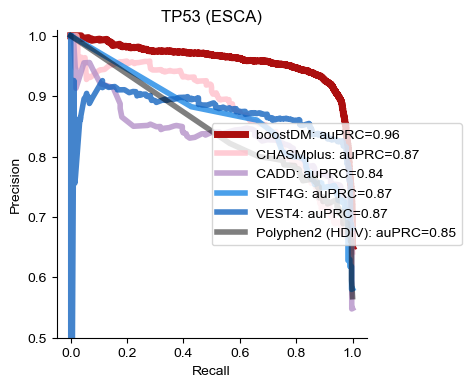

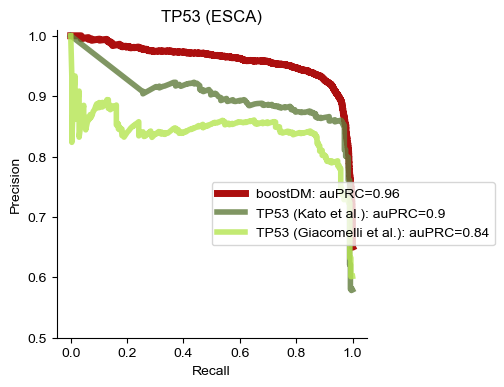

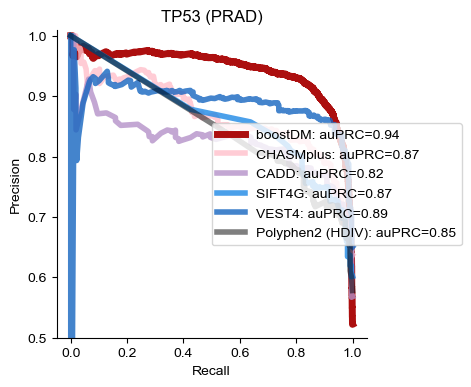

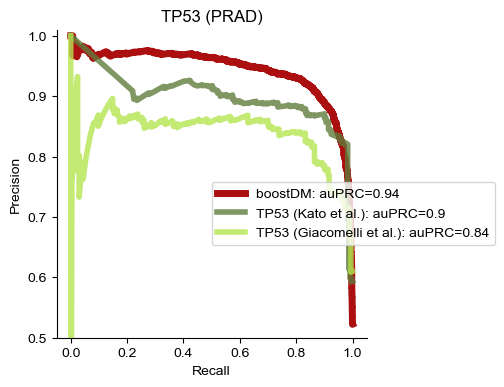

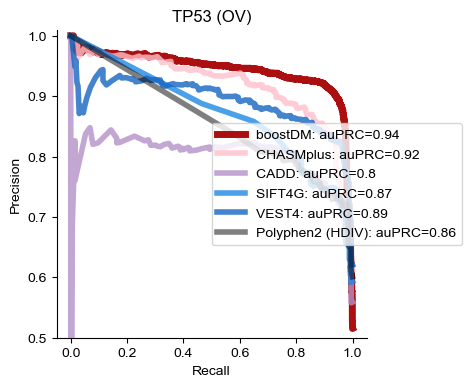

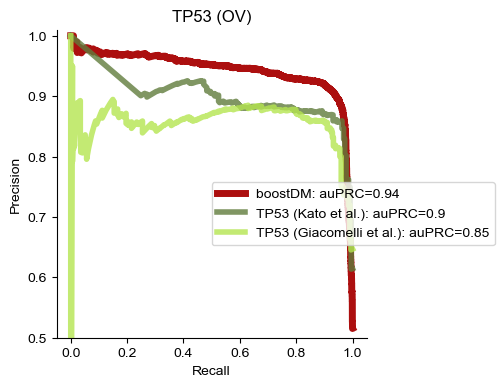

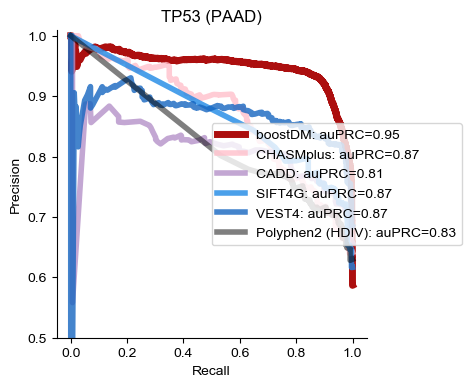

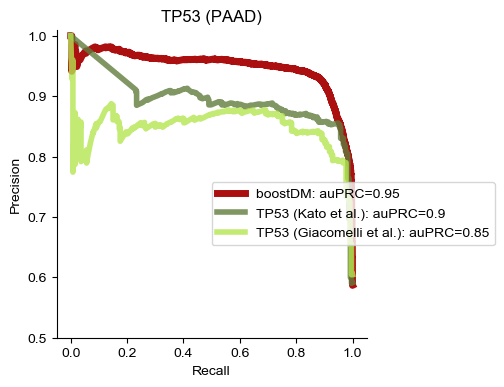

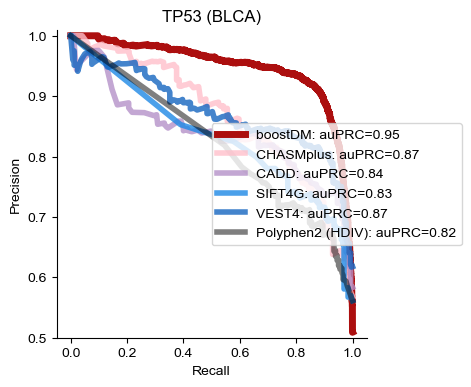

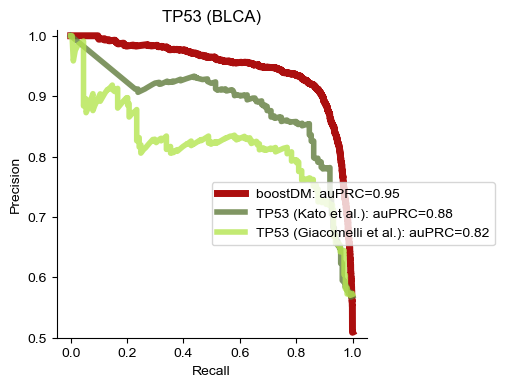

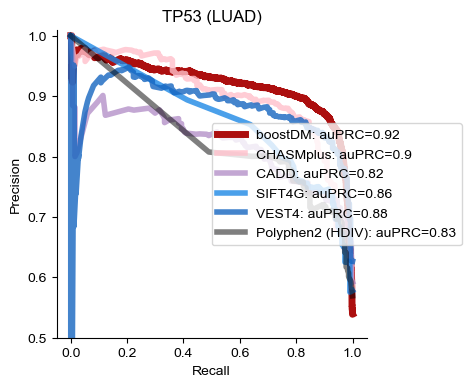

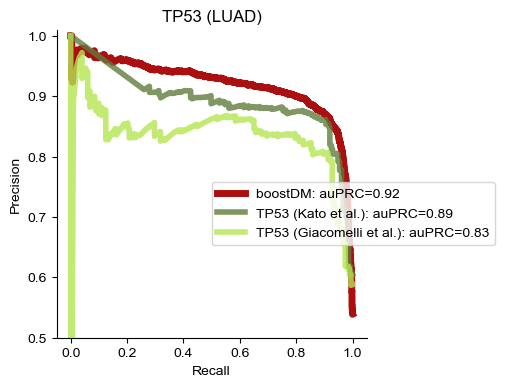

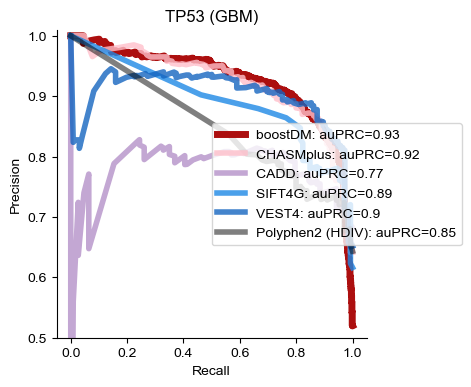

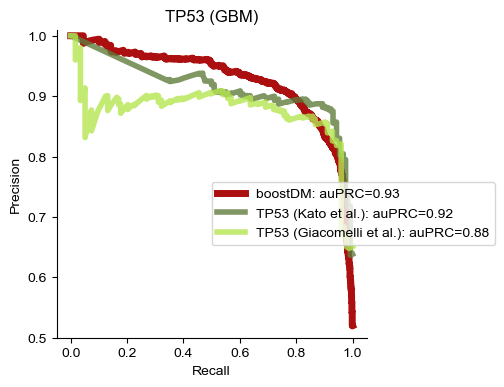

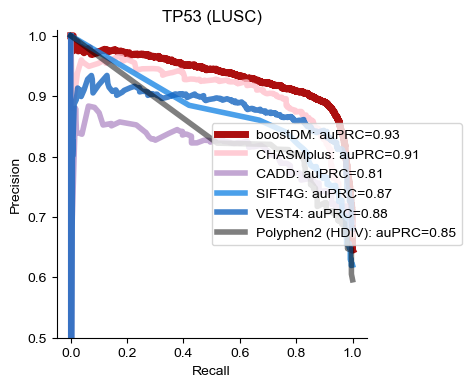

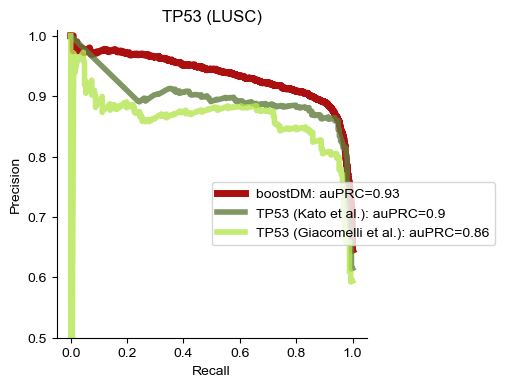

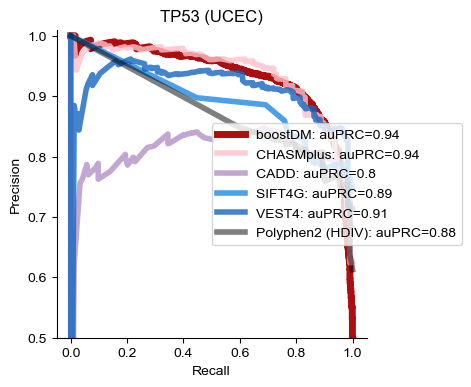

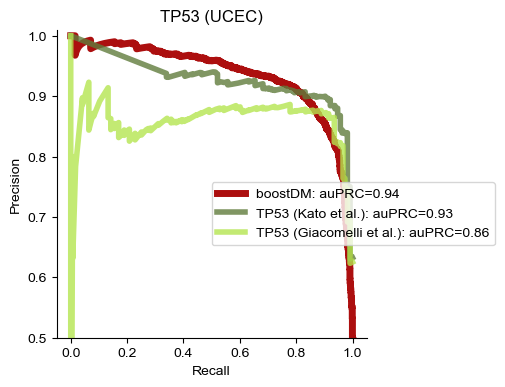

In [27]:
for ttype in {'PRAD', 'ESCA', 'LUSC', 'LUAD', 'UCEC', 'PAAD', 'OV', 'GBM', 'BLCA'}:
    gene = 'TP53'
    plot_tp53_bioinfo(gene, ttype)
    plot_tp53_experimental(gene, ttype)

# Extended Figure 3b

In [28]:
tree = oncotree.Oncotree()
leaves = tree.get_ttypes('CANCER')
with gzip.open(os.path.join(conf.output_boostdm, 'model_selection', 'eval_data.pickle.gz'), 'rb') as g:
    d = pickle.load(g)
gene_ttype_models = [(k[1], k[0]) for k, v in d.items() if (k == v) and (k[0] in leaves)]

In [29]:
def plot_kato_metric(gene, metric, mean=True, selected_labels=None):
    
    label = f'{gene.lower()}_score_categ' 
    
    boostdm_perf, method_perf, labels = [], [], []

    for fn in glob.glob(os.path.join(cv_path, f'cv_tp53_kato/*.*.performance_{gene.lower()}.tsv')):
        gene, ttype = tuple(os.path.basename(fn).split('.')[:2])
        
        try:
            
            # boostDM perf
            model_eval_folder = os.path.join(conf.output_boostdm, 'evaluation')
            with gzip.open(os.path.join(model_eval_folder, f'{ttype}/{gene}.eval.pickle.gz'), 'rb') as f:
                eval_obj = pickle.load(f)
            v_boostdm = eval_obj[metric]

            # metric perf
            df = pd.read_csv(fn, sep='\t')
            v_method = df[f'{metric}_{label}'].values
            assert(len(v_method) > 0)
            
        except:
            continue

        boostdm_perf.append(np.nanmedian(v_boostdm))
        method_perf.append(np.nanmedian(v_method))
        labels.append(f'{gene} ({ttype})')
    
    labels = np.array(labels)
    boostdm_perf = np.array(boostdm_perf)    
    method_perf = np.array(method_perf)
    b = ~np.isnan(method_perf)
    labels = list(labels[b])
    boostdm_perf = boostdm_perf[b]
    method_perf = method_perf[b]
    if selected_labels is not None:
        labels = [l if l in selected_labels else '' for l in labels]
    
    # plot data
    
    fig, ax = plt.subplots(figsize=(3,3))
    ax.set_aspect('equal')
    ax.scatter(boostdm_perf, method_perf, alpha=0.3, s=200)
    ax.plot([0.5, 1], [0.5, 1], '--', c='r', lw=4)
    if mean:
        for i, l in enumerate(labels):
            ax.text(boostdm_perf[i]+0.005, method_perf[i]+0.005, l, fontsize=10)
            if len(l) > 0:
                ax.scatter([boostdm_perf[i]], [method_perf[i]], 
                           edgecolors='black', s=200, c='white', alpha=0.5)
    
    ax.set_xlim(0.75, 1.0)
    ax.set_ylim(0.75, 1.0)
    ax.set_xlabel('boostDM (F-score)')
    ax.set_ylabel(f'{label.upper()} (F-score)')
    ax.set_title(f'Comparison against observed mutations\nacross CV test sets')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.savefig(f'./raw_plots/boostdm_vs_tp53_kato.strict.svg', dpi=300)
    plt.show()
    return labels

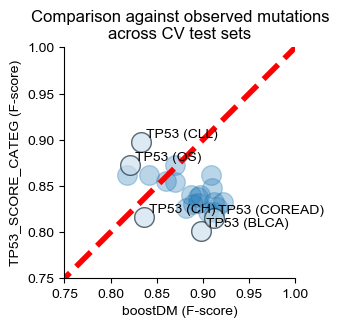

In [30]:
selected_gene_ttypes = [f'TP53 ({ttype})' for _, ttype in gene_ttype_models]
selected_gene_ttypes = ['TP53 (CLL)', 'TP53 (CH)', 'TP53 (BLCA)', 'TP53 (COREAD)', 'TP53 (BLCA)', 'TP53 (OS)']
labels = plot_kato_metric('TP53', 'fscore50', selected_labels=selected_gene_ttypes)

In [31]:
def plot_kato_metric_model(gene, metric, ttype):
    
    label = f'{gene.lower()}_score_categ'
    
    boostdm_perf = []
    method_perf = []
    
    # boostDM perf

    model_eval_folder = os.path.join(conf.output_boostdm, 'evaluation')
    with gzip.open(os.path.join(model_eval_folder, f'{ttype}/{gene}.eval.pickle.gz'), 'rb') as f:
        eval_obj = pickle.load(f)
    v_boostdm = eval_obj[metric]

    # metric perf

    fn = os.path.join(cv_path, f'cv_tp53_kato/{gene}.{ttype}.performance_{gene.lower()}.tsv')
    df = pd.read_csv(fn, sep='\t')
    v_method = df[f'{metric}_{label}'].values
    assert(len(v_method) > 0)

    boostdm_perf += v_boostdm
    method_perf += df[f'{metric}_{label}'].values.tolist()
    
    # plot data
    
    fig, ax = plt.subplots(figsize=(3,3))
    ax.scatter(boostdm_perf, method_perf, alpha=0.5)
    ax.plot([0.5, 1], [0.5, 1], '--', c='r', lw=2)
    ax.set_xlim(0.7, 1.05)
    ax.set_xlabel('boostDM (F-score)')
    ax.set_ylabel(f'{label.upper()} (F-score)')
    ax.set_title(f'{gene} {ttype}')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.savefig(f'./raw_plots/boostdm_vs_tp53_kato.{gene}.{ttype}.strict.svg', dpi=300)
    plt.show()

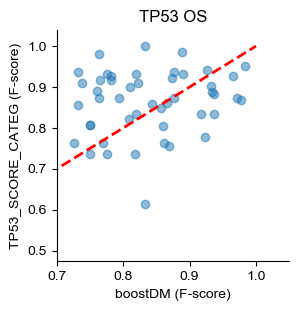

In [32]:
plot_kato_metric_model('TP53', 'fscore50', 'OS')

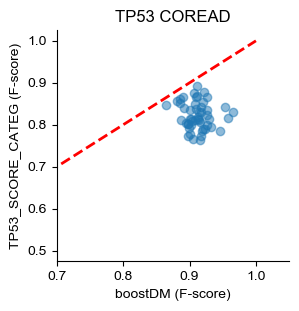

In [33]:
plot_kato_metric_model('TP53', 'fscore50', 'COREAD')

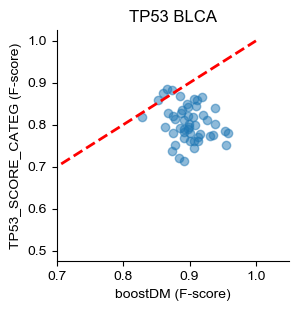

In [34]:
plot_kato_metric_model('TP53', 'fscore50', 'BLCA')

In [35]:
def plot_giacomelli_metric(gene, metric, mean=True, selected_labels=None):
    
    label = f'tp53_natgen_score_categ'
    
    boostdm_perf, method_perf, labels = [], [], []

    for fn in glob.glob(os.path.join(cv_path, 'cv_tp53_giacomelli/*.*.performance_tp53_natgen_score.tsv')):
        gene, ttype = tuple(os.path.basename(fn).split('.')[:2])
        
        try:
            
            # boostDM perf
            model_eval_folder = os.path.join(conf.output_boostdm, 'evaluation')
            with gzip.open(os.path.join(model_eval_folder, f'{ttype}/{gene}.eval.pickle.gz'), 'rb') as f:
                eval_obj = pickle.load(f)
            v_boostdm = eval_obj[metric]

            # metric perf
            df = pd.read_csv(fn, sep='\t')
            v_method = df[f'{metric}_{label}'].values
            assert(len(v_method) > 0)
            
        except:
            continue

        boostdm_perf.append(np.nanmedian(v_boostdm))
        method_perf.append(np.nanmedian(v_method))
        labels.append(f'{gene} ({ttype})')
    
    labels = np.array(labels)
    boostdm_perf = np.array(boostdm_perf)    
    method_perf = np.array(method_perf)
    b = ~np.isnan(method_perf)
    labels = list(labels[b])
    boostdm_perf = boostdm_perf[b]
    method_perf = method_perf[b]
    if selected_labels is not None:
        labels = [l if l in selected_labels else '' for l in labels]
    
    # plot data
    
    fig, ax = plt.subplots(figsize=(3,3))
    ax.set_aspect('equal')
    ax.scatter(boostdm_perf, method_perf, alpha=0.3, s=200)
    ax.plot([0.5, 1], [0.5, 1], '--', c='r', lw=4)
    if mean:
        for i, l in enumerate(labels):
            ax.text(boostdm_perf[i]+0.005, method_perf[i]+0.005, l, fontsize=10)
            if len(l) > 0:
                ax.scatter([boostdm_perf[i]], [method_perf[i]], 
                           edgecolors='black', s=200, c='white', alpha=0.5)
    
    ax.set_xlim(0.75, 1.0)
    ax.set_ylim(0.75, 1.0)
    ax.set_xlabel('boostDM (F-score)')
    ax.set_ylabel(f'TP53 Giacomelli et al. (F-score)')
    ax.set_title(f'Comparison against observed mutations\nacross CV test sets')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.savefig(f'./raw_plots/boostdm_vs_tp53_giacomelli.svg', dpi=300)
    plt.show()
    return labels

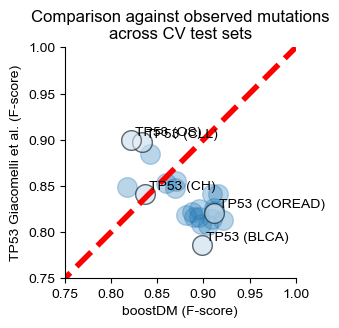

In [36]:
selected_gene_ttypes = [f'TP53 ({ttype})' for _, ttype in gene_ttype_models]
selected_gene_ttypes = ['TP53 (CLL)', 'TP53 (CH)', 'TP53 (BLCA)', 'TP53 (COREAD)', 'TP53 (BLCA)', 'TP53 (OS)']
labels = plot_giacomelli_metric('TP53', 'fscore50', selected_labels=selected_gene_ttypes)

In [37]:
def plot_giacomelli_metric_model(gene, metric, ttype):
    
    label = f'tp53_natgen_score_categ'
    
    boostdm_perf = []
    method_perf = []
    
    # boostDM perf

    model_eval_folder = os.path.join(conf.output_boostdm, 'evaluation')
    with gzip.open(os.path.join(model_eval_folder, f'{ttype}/{gene}.eval.pickle.gz'), 'rb') as f:
        eval_obj = pickle.load(f)
    v_boostdm = eval_obj[metric]

    # metric perf

    fn = os.path.join(cv_path, f'cv_tp53_giacomelli/{gene}.{ttype}.performance_tp53_natgen_score.tsv')
    df = pd.read_csv(fn, sep='\t')
    v_method = df[f'{metric}_{label}'].values
    assert(len(v_method) > 0)

    boostdm_perf += v_boostdm
    method_perf += df[f'{metric}_{label}'].values.tolist()
    
    # plot data
    
    fig, ax = plt.subplots(figsize=(3,3))
    ax.scatter(boostdm_perf, method_perf, alpha=0.5)
    ax.plot([0.5, 1], [0.5, 1], '--', c='r', lw=2)
    ax.set_xlim(0.7, 1.05)
    ax.set_xlabel('boostDM (F-score)')
    ax.set_ylabel(f'TP53 Giacomelli et al. (F-score)')
    ax.set_title(f'{gene} {ttype}')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.savefig(f'./raw_plots/boostdm_vs_tp53_giacomelli.{gene}.{ttype}.strict.svg')
    plt.show()

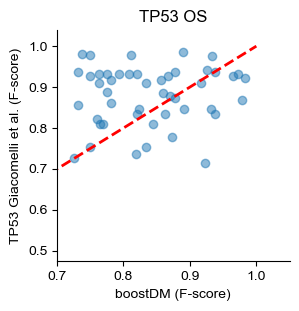

In [38]:
plot_giacomelli_metric_model('TP53', 'fscore50', 'OS')

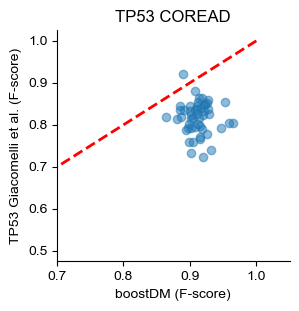

In [39]:
plot_giacomelli_metric_model('TP53', 'fscore50', 'COREAD')

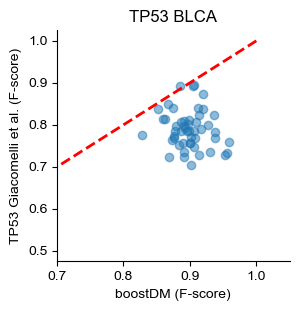

In [40]:
plot_giacomelli_metric_model('TP53', 'fscore50', 'BLCA')

# Extended Figure 3c

In [41]:
df = pd.read_csv(os.path.join(os.environ['PATH_SOURCE_DATA'], 'extended-figure3-source-data', 'bench_tp53_science.tsv'), sep='\t')
df = df[['aachange'] + [c for c in df.columns if c.startswith('boostDM')]]
df.drop_duplicates(inplace=True)

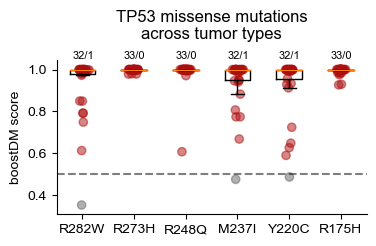

In [42]:
fig, ax = plt.subplots(figsize=(4,2))
labels = df['aachange'].tolist()
box = [list(v[1:]) for v in df.values]
x = functools.reduce(operator.concat, [[i+1] * len(b) for i,b in enumerate(box)])
x = x + np.random.normal(0, 0.05, size=len(x))
y = functools.reduce(operator.concat, box)
color = ['#ac0f0f' if v >= 0.5 else '#636363' for v in y]
proportion = [f'{sum([a >= 0.5 for a in v])}/{sum([a < 0.5 for a in v])}' for v in box]
for i, p in enumerate(proportion):
    ax.text(i+0.8, 1.05, p, fontsize=8)
ax.hlines(0.5, 0.5, 6.5, linestyles='dashed', alpha=0.5)
ax.boxplot(box, showfliers=False)
ax.scatter(x, y, alpha=0.5, c=color)
ax.set_ylabel('boostDM score')
ax.set_xticklabels(labels)
ax.set_title('TP53 missense mutations\nacross tumor types', pad=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('./raw_plots/tp53_science_predictions.svg', dpi=300)
plt.show()

# Extended Figure 3d

In [43]:
def plot_ras(gene, ttype):
    
    fig, ax = plt.subplots(figsize=(4,4))
    lw = 4
    alpha = 0.8
    plot_prc(gene, ttype, 'boostDM_score', ax, color=palettes['boostDM_score'], lw=5, alpha=1)
    plot_prc(gene, ttype, 'ras_bandaru', ax, color=palettes['ras_bandaru'], lw=5, alpha=1)
    plot_prc(gene, ttype, 'chasm_score', ax, color=palettes['chasm_score'], lw=lw, alpha=alpha)
    plot_prc(gene, ttype, 'cadd_score', ax, color=palettes['cadd_score'], lw=lw, alpha=alpha)
    plot_prc(gene, ttype, 'sift4g', ax, color=palettes['sift4g'], lw=lw, alpha=alpha)
    plot_prc(gene, ttype, 'vest4', ax, color=palettes['vest4'], lw=lw, alpha=alpha)
    plot_prc(gene, ttype, 'Polyphen2_HDIV', ax, color=palettes['Polyphen2_HDIV'], lw=lw, alpha=0.5)
    
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(f'{gene} ({ttype})')
    ax.legend(loc=(0.5, 0.3))
    plt.savefig(f'./raw_plots/{gene}.{ttype}.prc.overall.svg', bbox_inches='tight')
    plt.show()

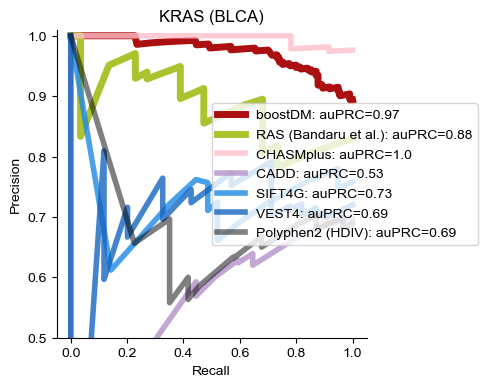

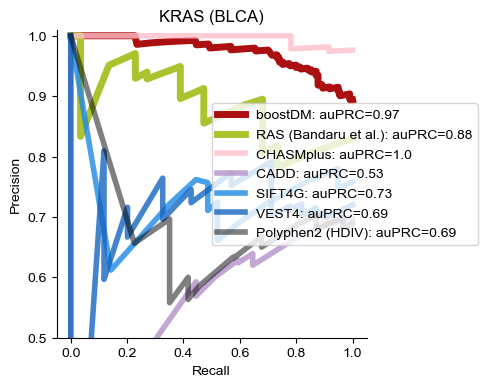

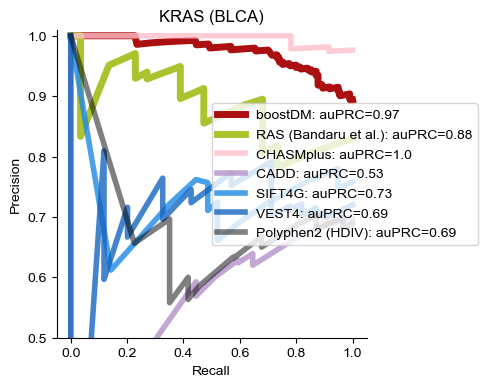

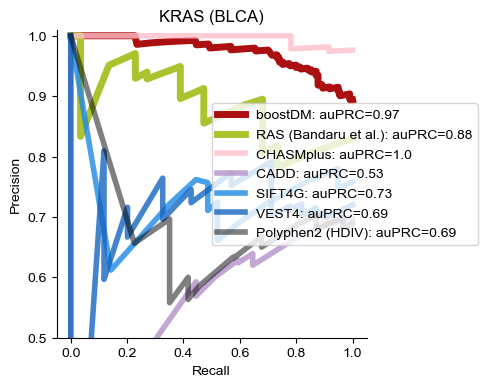

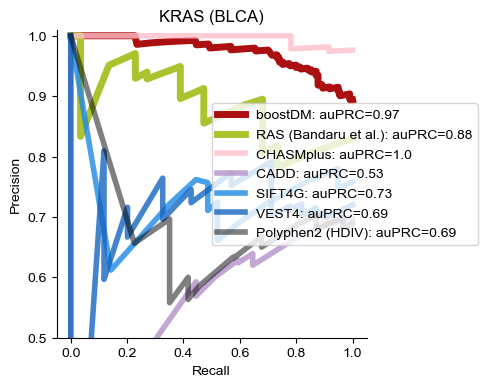

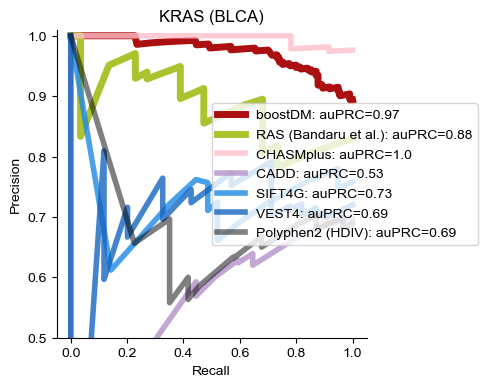

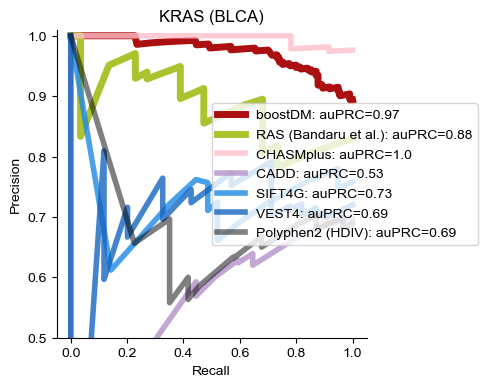

In [44]:
for gene, ttype in [('KRAS', 'BLCA'), ('KRAS', 'PAAD'), ('KRAS', 'OV'), ('KRAS', 'LUAD'), 
                    ('HRAS', 'BLCA'), ('HRAS', 'THCA'), ('NRAS', 'THCA')]:
    plot_ras('KRAS', 'BLCA')

# Extended Figure 3e

In [45]:
def plot_several_ras_boxplot():

    fig, ax = plt.subplots(figsize=(10,3))
    
    method_label_reduced = {k: v for k, v in method_label.items() if 
                            k not in ['tp53_kato', 'tp53_giacomelli', 'pten_mighell']}

    scores, scores_full = zip(*list(method_label_reduced.items()))
    box = [[] for _ in scores]
    
    for gene, ttype in [('KRAS', 'BLCA'), ('KRAS', 'PAAD'), ('KRAS', 'OV'), ('KRAS', 'LUAD'), ('HRAS', 'BLCA'), ('HRAS', 'THCA'), ('NRAS', 'THCA')]:
        for i, score in enumerate(scores):
            try:
                auc, _, _, _, _ = plot_prc(gene, ttype, score, ax=ax, plot=False, lw=4, alpha=1)
                box[i].append(auc)
            except:
                continue
    
    sorted_index = np.argsort(list(map(np.nanmedian, box)))[::-1]
    box = [box[i] for i in sorted_index]
    scores_full = [scores_full[i] for i in sorted_index]

    ax.boxplot(box, showfliers=False)
    x = [[i+1] * len(b) for i, b in enumerate(box)]
    x = functools.reduce(operator.concat, x)
    x = np.array(x) + np.random.normal(0, 0.05, size=len(x))
    
    colors = [[palettes[scores[i]]] * len(b) for i, b in enumerate(box)]
    colors = functools.reduce(operator.concat, colors)
    y = functools.reduce(operator.concat, box)
    ax.scatter(x, y, c=colors, s=30)
    ax.set_ylabel('auPRC')
    ax.set_xlabel('Method')
    ax.set_xticklabels(scores_full, rotation=90)
    ax.set_title('Agreement across RAS genes and tumor types')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.savefig('./raw_plots/RAS.boxplot.svg', bbox_inches='tight')
    plt.show()

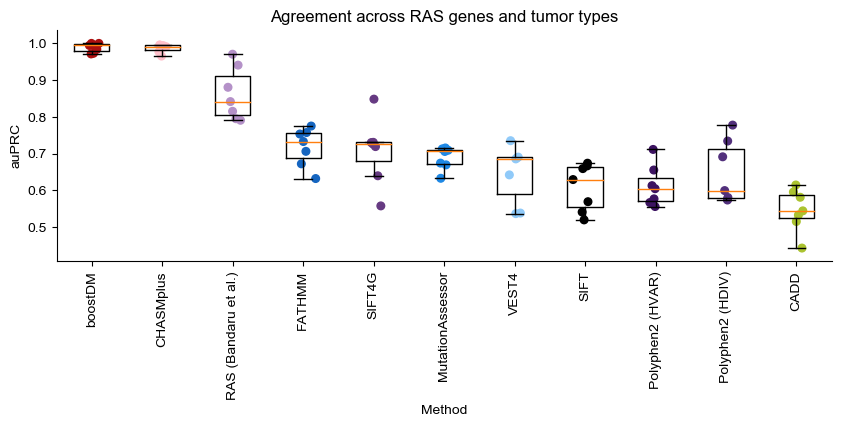

In [46]:
plot_several_ras_boxplot()

# Extended Figure 3f

In [47]:
def plot_pten_bioinfo(gene, ttype):
    
    fig, ax = plt.subplots(figsize=(4,4))
    lw = 4
    alpha = 0.8
    plot_prc(gene, ttype, 'boostDM_score', ax, color=palettes['boostDM_score'], lw=5, alpha=1)
    plot_prc(gene, ttype, 'chasm_score', ax, color=palettes['chasm_score'], lw=lw, alpha=alpha)
    plot_prc(gene, ttype, 'cadd_score', ax, color=palettes['cadd_score'], lw=lw, alpha=alpha)
    plot_prc(gene, ttype, 'sift4g', ax, color=palettes['sift4g'], lw=lw, alpha=alpha)
    plot_prc(gene, ttype, 'vest4', ax, color=palettes['vest4'], lw=lw, alpha=alpha)
    plot_prc(gene, ttype, 'Polyphen2_HDIV', ax, color=palettes['Polyphen2_HDIV'], lw=lw, alpha=0.5)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(f'{gene} ({ttype})')
    ax.legend(loc=(0.5, 0.3))
    plt.savefig(f'./raw_plots/{gene}.{ttype}.prc.bioinfo.svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    
def plot_pten_experimental(gene, ttype):
    
    fig, ax = plt.subplots(figsize=(4,4))
    lw = 4
    alpha = 0.8
    plot_prc(gene, ttype, 'boostDM_score', ax, color=palettes['boostDM_score'], lw=5, alpha=1)
    plot_prc(gene, ttype, 'pten_mighell', ax, color=palettes['pten_mighell'], lw=lw, alpha=alpha)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(f'{gene} ({ttype})')
    ax.legend(loc=(0.5, 0.3))
    plt.savefig(f'./raw_plots/{gene}.{ttype}.prc.experimental.svg', dpi=300, bbox_inches='tight')
    plt.show()

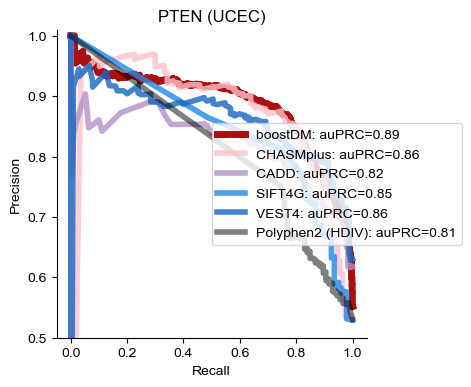

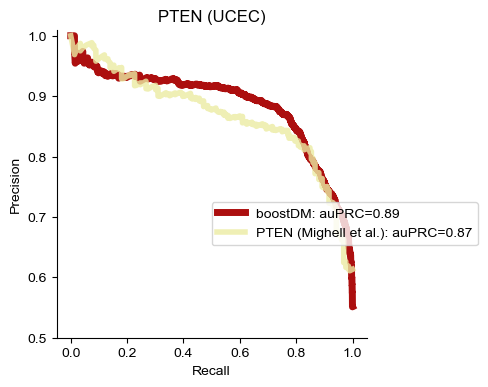

In [48]:
gene, ttype = 'PTEN', 'UCEC'
plot_pten_bioinfo(gene, ttype)
plot_pten_experimental(gene, ttype)

# Extended Figure 3g

In [49]:
def plot_bioinfo(gene, ttype):
    
    fig, ax = plt.subplots(figsize=(4,4))
    lw = 4
    alpha = 0.8
    plot_prc(gene, ttype, 'boostDM_score', ax, color=palettes['boostDM_score'], lw=5, alpha=1)
    plot_prc(gene, ttype, 'chasm_score', ax, color=palettes['chasm_score'], lw=lw, alpha=alpha)
    plot_prc(gene, ttype, 'cadd_score', ax, color=palettes['cadd_score'], lw=lw, alpha=alpha)
    plot_prc(gene, ttype, 'sift4g', ax, color=palettes['sift4g'], lw=lw, alpha=alpha)
    plot_prc(gene, ttype, 'vest4', ax, color=palettes['vest4'], lw=lw, alpha=alpha)
    plot_prc(gene, ttype, 'Polyphen2_HDIV', ax, color=palettes['Polyphen2_HDIV'], lw=lw, alpha=0.5)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(f'{gene} ({ttype})')
    ax.legend(loc=(0.5, 0.3))
    plt.savefig(f'./raw_plots/{gene}.{ttype}.prc.bioinfo.svg', dpi=300, bbox_inches='tight')
    plt.show()

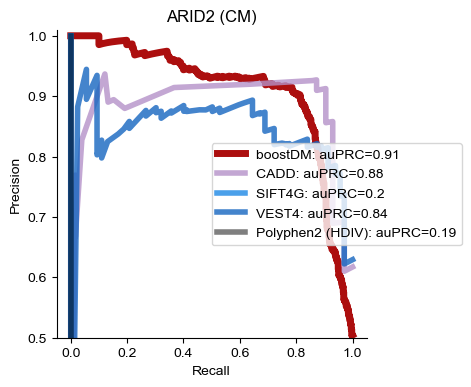

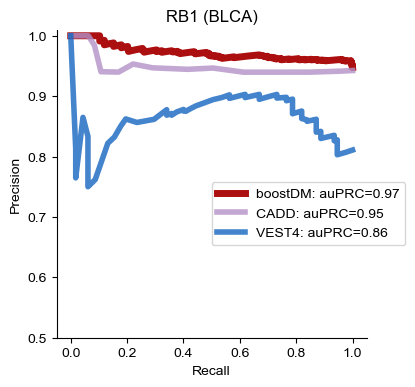

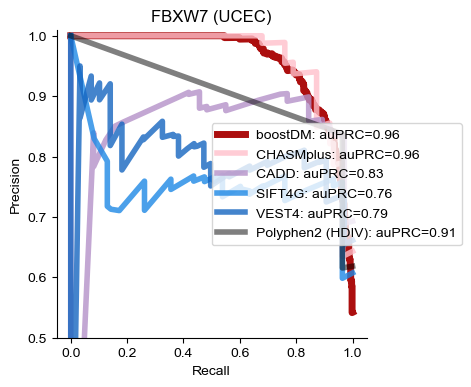

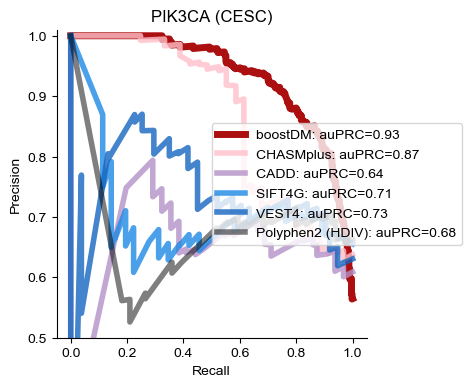

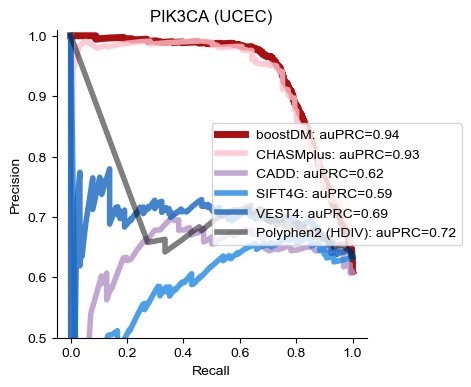

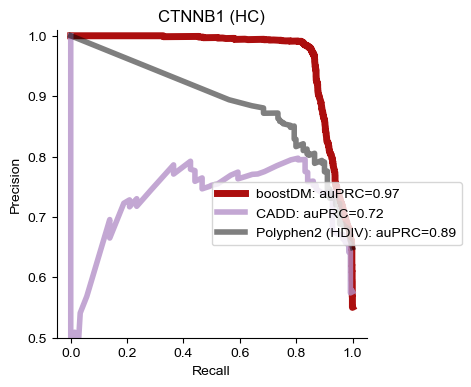

In [50]:
for gene, ttype in [('ARID2', 'CM'), ('RB1', 'BLCA'), ('FBXW7', 'UCEC'), 
                    ('PIK3CA', 'CESC'), ('PIK3CA', 'UCEC'), ('CTNNB1', 'HC')]:
    plot_bioinfo(gene, ttype)

# Extended Figure 3h

In [51]:
def plot_chasm_metric(metric, mean=True, threshold='standard', selected_labels=None):
    
    method = 'chasm'
    
    if threshold == 'standard':
        path = os.path.join(cv_path, 'cv_chasm/*.*.performance_chasm.tsv')
    elif threshold == 'qval0':        
        path = os.path.join(cv_path, f'cv_chasm/*.*.performance_chasm_{threshold}.tsv')
    
    boostdm_perf, method_perf, labels = [], [], []

    for fn in glob.glob(path):
        gene, ttype = tuple(os.path.basename(fn).split('.')[:2])
        
        try:    
            # boostDM perf
            model_eval_folder = os.path.join(conf.output_boostdm, 'evaluation')
            with gzip.open(os.path.join(model_eval_folder, f'{ttype}/{gene}.eval.pickle.gz'), 'rb') as f:
                eval_obj = pickle.load(f)
            v_boostdm = eval_obj[metric]

            # metric perf
            df = pd.read_csv(fn, sep='\t')
            v_method = df[f'{metric}_{method}'].values
            assert(len(v_method) > 0)
            
        except:
            continue

        boostdm_perf.append(np.nanmedian(v_boostdm))
        method_perf.append(np.nanmedian(v_method))
        labels.append(f'{gene} ({ttype})')
    
    labels = np.array(labels)
    boostdm_perf = np.array(boostdm_perf)    
    method_perf = np.array(method_perf)
    b = ~np.isnan(method_perf)
    labels = list(labels[b])
    boostdm_perf = boostdm_perf[b]
    method_perf = method_perf[b]
    if selected_labels is not None:
        labels = [l if l in selected_labels else '' for l in labels]
    
    # plot data
    
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_aspect('equal')
    ax.scatter(boostdm_perf, method_perf, alpha=0.3, s=200)
    ax.plot([0.5, 1], [0.5, 1], '--', c='r', lw=4)
    if mean:
        for i, l in enumerate(labels):
            ax.text(boostdm_perf[i]+0.01, method_perf[i]+0.01, l, fontsize=10)
            if len(l) > 0:
                ax.scatter([boostdm_perf[i]], [method_perf[i]], edgecolors='black', s=200, c='white', alpha=0.5)
    
    ax.set_xlim(0.75, 1.05)
    ax.set_ylim(0.5, 1.05)
    ax.set_xlabel('boostDM (F-score)')
    ax.set_ylabel(f'{method.upper()} (F-score)')
    ax.set_title(f'Comparison against observed mutations\nacross CV test sets ({threshold})')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.savefig(f'./raw_plots/boostdm_vs_chasm.{threshold}.svg')
    plt.show()
    return labels

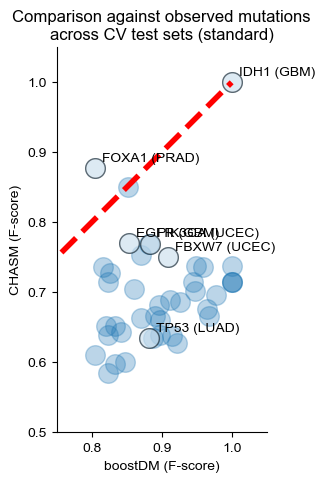

In [52]:
selected_gene_ttypes = ['TP53 (LUAD)', 'EGFR (GBM)', 'FBXW7 (UCEC)', 'PIK3CA (UCEC)', 'IDH1 (GBM)', 'FOXA1 (PRAD)']
labels = plot_chasm_metric('fscore50', selected_labels=selected_gene_ttypes, threshold='standard')

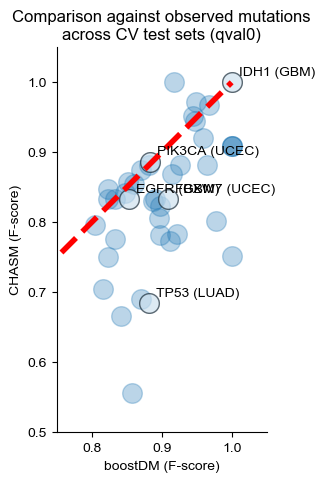

In [53]:
selected_gene_ttypes = ['TP53 (LUAD)', 'EGFR (GBM)', 'FBXW7 (UCEC)', 'PIK3CA (UCEC)', 'IDH1 (GBM)']
labels = plot_chasm_metric('fscore50', selected_labels=selected_gene_ttypes, threshold='qval0')

In [54]:
def plot_chasm_metric_model(metric, gene, ttype, threshold='standard'):
    
    method = 'chasm'
    
    if threshold == 'standard':
        path = os.path.join(cv_path, f'cv_chasm/{gene}.{ttype}.performance_chasm.tsv')
    elif threshold == 'qval0':        
        path = os.path.join(cv_path, f'cv_chasm/{gene}.{ttype}.performance_chasm_{threshold}.tsv')
        
    boostdm_perf = []
    method_perf = []
    
    # boostDM perf

    model_eval_folder = os.path.join(conf.output_boostdm, 'evaluation')
    with gzip.open(os.path.join(model_eval_folder, f'{ttype}/{gene}.eval.pickle.gz'), 'rb') as f:
        eval_obj = pickle.load(f)
    v_boostdm = eval_obj[metric]

    # metric perf

    df = pd.read_csv(path, sep='\t')
    v_method = df[f'{metric}_{method}'].values
    assert(len(v_method) > 0)

    boostdm_perf += v_boostdm
    method_perf += df[f'{metric}_{method}'].values.tolist()
    
    # plot data
    
    fig, ax = plt.subplots(figsize=(3,3))
    ax.scatter(boostdm_perf, method_perf, alpha=0.5)
    ax.plot([0.5, 1], [0.5, 1], '--', c='r', lw=2)
    ax.set_xlim(0.75, 1.05)
    ax.set_xlabel('boostDM (F-score)')
    ax.set_ylabel(f'{method.upper()} (F-score)')
    ax.set_title(f'{gene} {ttype} ({threshold})')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.savefig(f'./raw_plots/boostdm_vs_chasm.{gene}.{ttype}.{threshold}.svg')
    plt.show()

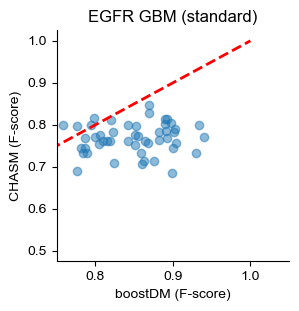

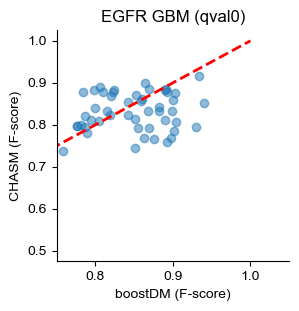

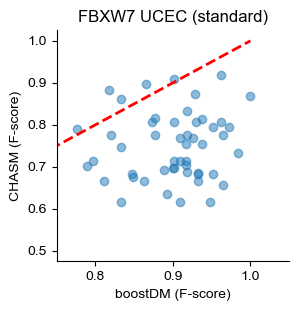

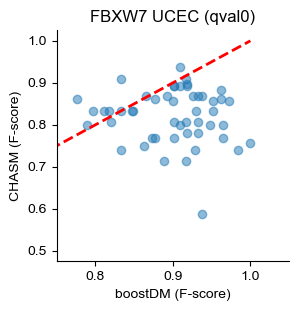

In [55]:
plot_chasm_metric_model('fscore50', 'EGFR', 'GBM', threshold='standard')
plot_chasm_metric_model('fscore50', 'EGFR', 'GBM', threshold='qval0')
plot_chasm_metric_model('fscore50', 'FBXW7', 'UCEC', threshold='standard')
plot_chasm_metric_model('fscore50', 'FBXW7', 'UCEC', threshold='qval0')

# Extended Figure 3i

In [56]:
def plot_cadd_metric(method, metric, threshold=10, mean=True, selected_labels=None):
    
    boostdm_perf, method_perf, labels = [], [], []

    for fn in glob.glob(os.path.join(cv_path, f'cv_{method}/*.*.performance_{method}.{threshold}.tsv')):
        gene, ttype = tuple(os.path.basename(fn).split('.')[:2])
        
        try:    
            # boostDM perf
            
            model_eval_folder = os.path.join(conf.output_boostdm, 'evaluation')
            with gzip.open(os.path.join(model_eval_folder, f'{ttype}/{gene}.eval.pickle.gz'), 'rb') as f:
                eval_obj = pickle.load(f)
            v_boostdm = eval_obj[metric]

            # metric perf
            
            df = pd.read_csv(fn, sep='\t')
            v_method = df[f'{metric}_{method}'].values
            assert(len(v_method) > 0)
            
        except:
            continue

        boostdm_perf.append(np.nanmedian(v_boostdm))
        method_perf.append(np.nanmedian(v_method))
        labels.append(f'{gene} ({ttype})')
    
    labels = np.array(labels)
    boostdm_perf = np.array(boostdm_perf)    
    method_perf = np.array(method_perf)
    b = ~np.isnan(method_perf)
    labels = list(labels[b])
    boostdm_perf = boostdm_perf[b]
    method_perf = method_perf[b]
    if selected_labels is not None:
        labels = [l if l in selected_labels else '' for l in labels]
    
    # plot data
    
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_aspect('equal')
    ax.scatter(boostdm_perf, method_perf, alpha=0.3, s=200)
    ax.plot([0.5, 1], [0.5, 1], '--', c='r', lw=4)
    if mean:
        for i, l in enumerate(labels):
            ax.text(boostdm_perf[i]+0.01, method_perf[i]+0.01, l, fontsize=10)
            if len(l) > 0:
                ax.scatter([boostdm_perf[i]], [method_perf[i]], edgecolors='black', s=200, c='white', alpha=0.5)
    
    ax.set_xlim(0.75, 1.05)
    ax.set_ylim(0.5, 1.05)
    ax.set_xlabel('boostDM (F-score)')
    ax.set_ylabel(f'{method.upper()} (F-score)')
    ax.set_title(f'Comparison against observed mutations\nacross CV test sets: {method.upper()} $\geq$ {threshold}')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.savefig(f'./raw_plots/boostdm_vs_cadd.{threshold}.svg')
    plt.show()
    return labels

In [57]:
selected_gene_ttypes = ['TP53 (LUAD)', 'EGFR (GBM)', 'FBXW7 (UCEC)', 'PIK3CA (UCEC)', 'IDH1 (GBM)', 'FOXA1 (PRAD)']

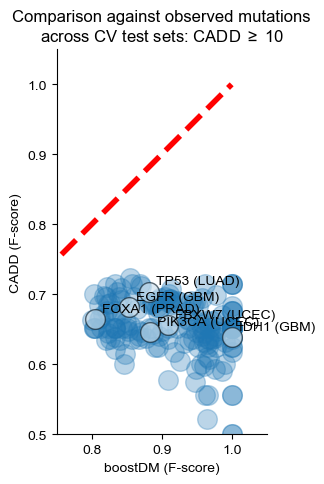

In [58]:
labels = plot_cadd_metric('cadd', 'fscore50', selected_labels=selected_gene_ttypes)

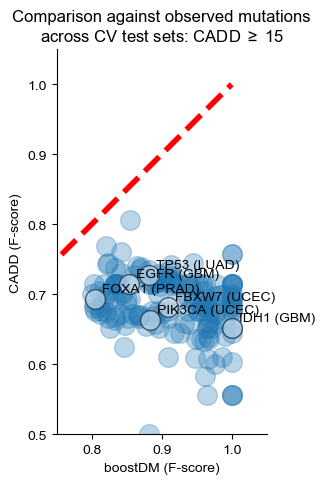

In [59]:
labels = plot_cadd_metric('cadd', 'fscore50', threshold=15, selected_labels=selected_gene_ttypes)

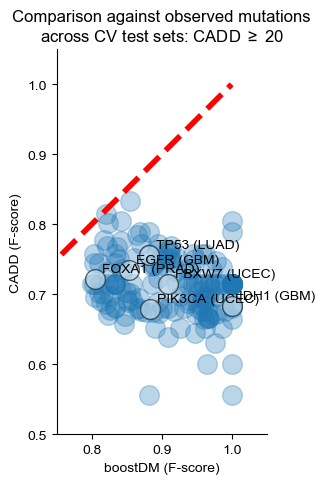

In [60]:
labels = plot_cadd_metric('cadd', 'fscore50', threshold=20, selected_labels=selected_gene_ttypes)

In [61]:
def plot_cadd_metric_model(method, metric, gene, ttype, threshold=10):
    
    boostdm_perf = []
    method_perf = []
    
    # boostDM perf

    model_eval_folder = os.path.join(conf.output_boostdm, 'evaluation')
    with gzip.open(os.path.join(model_eval_folder, f'{ttype}/{gene}.eval.pickle.gz'), 'rb') as f:
        eval_obj = pickle.load(f)
    v_boostdm = eval_obj[metric]

    # metric perf

    fn = os.path.join(cv_path, f'cv_{method}/{gene}.{ttype}.performance_{method}.{threshold}.tsv')
    df = pd.read_csv(fn, sep='\t')
    v_method = df[f'{metric}_{method}'].values
    assert(len(v_method) > 0)

    boostdm_perf += v_boostdm
    method_perf += df[f'{metric}_{method}'].values.tolist()
    
    # plot data
    
    fig, ax = plt.subplots(figsize=(3,3))
    ax.scatter(boostdm_perf, method_perf, alpha=0.5)
    ax.plot([0.5, 1], [0.5, 1], '--', c='r', lw=2)
    ax.set_xlim(0.75, 1.05)
    ax.set_xlabel('boostDM (F-score)')
    ax.set_ylabel(f'{method.upper()} (F-score)')
    ax.set_title(f'{gene} {ttype} ({method.upper()} $\geq$ {threshold})')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.savefig(f'./raw_plots/boostdm_vs_cadd.{gene}.{ttype}.{threshold}.svg', dpi=300)
    plt.show()

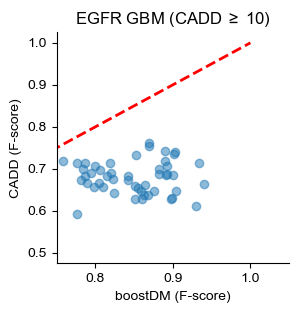

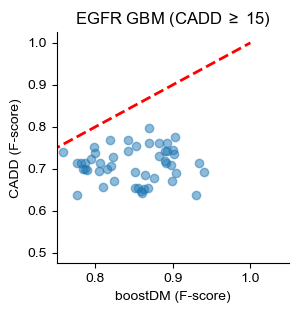

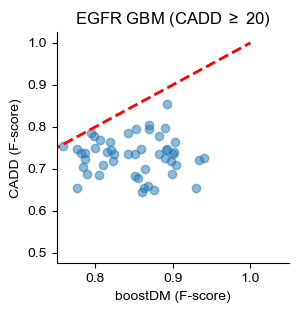

In [62]:
plot_cadd_metric_model('cadd', 'fscore50', 'EGFR', 'GBM', threshold=10)
plot_cadd_metric_model('cadd', 'fscore50', 'EGFR', 'GBM', threshold=15)
plot_cadd_metric_model('cadd', 'fscore50', 'EGFR', 'GBM', threshold=20)

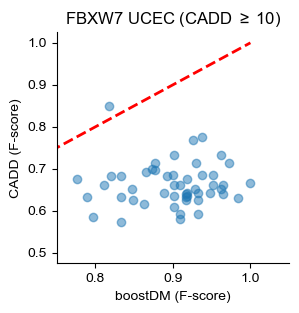

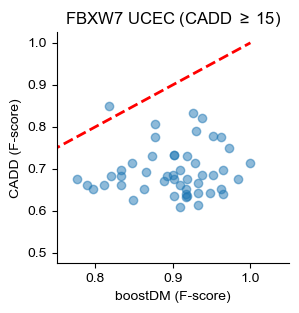

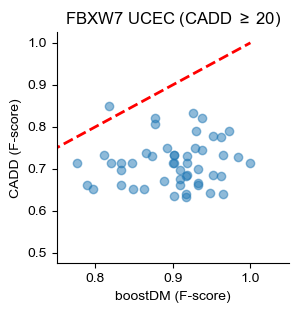

In [63]:
plot_cadd_metric_model('cadd', 'fscore50', 'FBXW7', 'UCEC', threshold=10)
plot_cadd_metric_model('cadd', 'fscore50', 'FBXW7', 'UCEC', threshold=15)
plot_cadd_metric_model('cadd', 'fscore50', 'FBXW7', 'UCEC', threshold=20)